In [1]:
import keras.datasets.mnist as mnist

train, test = mnist.load_data()
x_train, y_train = train
x_test, y_test = test
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


0


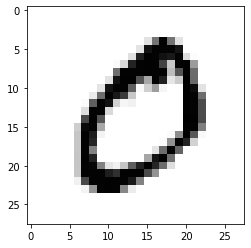

In [2]:
import matplotlib.pyplot as plt

i = 1
plt.imshow(x_train[i].reshape(28,28), cmap='Greys')
print(y_train[i])

In [3]:
import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.activations import relu, softmax
from keras.models import Model, load_model, Sequential
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.optimizers import Adam

In [ ]:
y_train = to_categorical(y_train)
y_train.shape

(60000, 10)

In [4]:
def convolutional_block(x, filters):
  ch1, ch2, ch3 = filters
  x_res = Conv2D(ch3, (1,1), strides=(2,2), padding='same', kernel_regularizer=l2(0.005))(x)
  x_res = BatchNormalization()(x_res)
  x = Conv2D(ch1, (1,1), strides=(2,2), padding='same', kernel_regularizer=l2(0.005))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(ch2, (3,3), padding='same', kernel_regularizer=l2(0.005))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(ch3, (1,1), padding='same', kernel_regularizer=l2(0.005))(x)
  x = BatchNormalization()(x)
  x = Add()([x, x_res])
  x = Activation('relu')(x)
  return x

def identity_block(x, filters):
  ch1, ch2, ch3 = filters
  x_res = x
  x = Conv2D(ch1, (1,1), padding='same', kernel_regularizer=l2(0.005))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(ch2, (3,3), padding='same', kernel_regularizer=l2(0.005))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(ch3, (1,1), padding='same', kernel_regularizer=l2(0.005))(x)
  x = BatchNormalization()(x)
  x = Add()([x, x_res])
  x = Activation('relu')(x)
  return x

In [5]:
def coniden_block(x, filter, num_iden=2):
  x = convolutional_block(x, filter)
  for _ in range(num_iden):
    x = identity_block(x, filter)
  return x

In [6]:
inputs = Input(shape=(28,28,1))

x = ZeroPadding2D((2, 2))(inputs)

x = Conv2D(16, (5,5), strides=(2,2), padding='same', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x) 
# (16,16,16)
x = coniden_block(x, (8,8,32), 2)
# (8,8,32)
x = coniden_block(x, (16,16,64), 2)
# (4,4,64)
x = coniden_block(x, (32,32,128), 2)
# (2,2,128)
x = coniden_block(x, (64,64,256), 2)
# (1,1,256)
x = Flatten()(x)
x = Dropout(0.4)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 16)   416         zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 16)   64          conv2d[0][0]                     
_______________________________________________________________________________________

In [7]:
model

In [ ]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs = 100, batch_size = 128)

Epoch 1/100
375/375 [==============================] - 7s 19ms/step - loss: 8.6538 - accuracy: 0.5399 - val_loss: 6.5691 - val_accuracy: 0.7625
Epoch 2/100
375/375 [==============================] - 6s 16ms/step - loss: 5.1656 - accuracy: 0.8414 - val_loss: 4.1314 - val_accuracy: 0.8790
Epoch 3/100
375/375 [==============================] - 7s 17ms/step - loss: 3.3741 - accuracy: 0.9072 - val_loss: 2.7875 - val_accuracy: 0.9268
Epoch 4/100
375/375 [==============================] - 7s 18ms/step - loss: 2.3863 - accuracy: 0.9314 - val_loss: 2.0644 - val_accuracy: 0.9307
Epoch 5/100
375/375 [==============================] - 6s 16ms/step - loss: 1.7612 - accuracy: 0.9473 - val_loss: 1.5999 - val_accuracy: 0.9333
Epoch 6/100
375/375 [==============================] - 6s 15ms/step - loss: 1.3487 - accuracy: 0.9549 - val_loss: 3.3844 - val_accuracy: 0.8295
Epoch 7/100
375/375 [==============================] - 6s 16ms/step - loss: 1.0862 - accuracy: 0.9577 - val_loss: 0.9873 - val_accuracy:

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


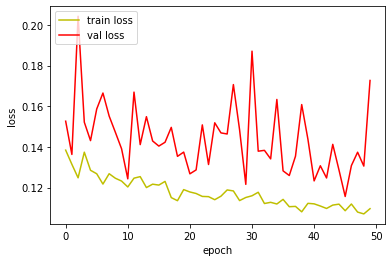

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'][50:], 'y', label='train loss')
plt.plot(hist.history['val_loss'][50:], 'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')

plt.show()

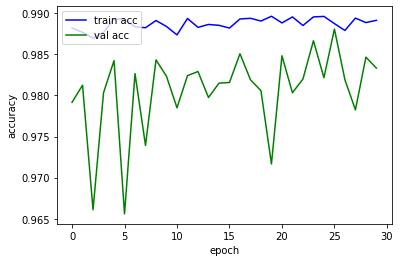

In [ ]:
plt.plot(hist.history['accuracy'][70:], 'b', label='train acc')
plt.plot(hist.history['val_accuracy'][70:], 'g', label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper left')

plt.show()